# Coronavirus Genome Analysis

**TABLE OF CONTENTS**

1. [Fetch data (from NCBI)](#section1)
2. [Exploratory data analysis)](#section2)

**Disclaimer**: this notebook is still under construction.

In [1]:
from matplotlib import pyplot as plt

from IPython.display import display, HTML
from IPython.display import Markdown as md

from sklearn.linear_model import LinearRegression

from Bio import SeqIO
from Bio import Entrez

import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib

from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import os
import lzma as xz

# data folders
root_folder = "./data/genbank/"
viruses = ["coronaviridae"]
cache_file = "cache.csv" # file periodically removed

hidden_columns = ["sequence", "file_path"]

max_unknown_nucleotides = 10

# 1. Fetch data (from NCBI) <a id="section1"></a>

Fetch the latest data from NCBI using keywords and a genome size range.

In [2]:
base_folder = "./data/genbank/"

Entrez.email = 'pellegre.esteban@gmail.com'
size_and_date = "(\"28000\"[SLEN] : \"35000\"[SLEN]) AND (\"2019/12/01\"[PDAT] : \"2020/12/31\"[PDAT])"
genbank_search_query = {"coronaviridae": ["SARS-CoV-2[All Fields] AND " + size_and_date,
                                          "2019-nCoV[All Fields] AND " + size_and_date,
                                          "coronavirus[All Fields] AND " + size_and_date]}

def fetch_gb(path, gid):
    handle = Entrez.efetch(db='nucleotide', id=gid, rettype='gb')
    local_file = open(path + "/" + gid + ".gb", 'w')
    local_file.write(handle.read())
    handle.close()
    local_file.close()

genome_files = genbank_search_query
viruses = genbank_search_query.keys()
    
count = 0
for vrs in viruses:
    
    data_folder = base_folder + vrs
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    for keywords in genome_files[vrs]:
        handle = Entrez.esearch(db="nucleotide", retmax=500, term=keywords, idtype="acc")
        record = Entrez.read(handle)
        ids = record["IdList"]
        handle.close()

        for genbank_id in ids:
            file_name = data_folder + "/" + genbank_id + ".gb"
            count += 1
            if not os.path.exists(file_name):
                print("[+]  --- * fetching (", vrs, ")", file_name)
                downloaded = False
                count = 0
                while not downloaded:
                    try:
                        fetch_gb(data_folder, genbank_id)
                        downloaded = True
                    except:
                        if count == 5:
                            print("[+]  --- * couldn't get (", vrs, ")", genbank_id)
                            break
                        count += 1
                        time.sleep(3)
                        pass

print("[+] Collected", count, " gb files")

[+] Collected 436  gb files


# 2. Exploratory data analysis <a id="section2"></a>

First of all, let's take a look to the data structure and condense it on a data frame. We are only looking at complete genomes downloaded from NCBI.

In [3]:
def get_genomes():
    for vrs in viruses:    
        # define data frame structure
        feature_columns = ["country", "host", "strain", "collection_date"]
        sample_columns = ["id", "length", "date", "information", "description", "sequence", "file_path"]
        total_columns = sample_columns + feature_columns
        vrs_frame = {i:list() for i in total_columns}

        # loop over gb files
        data_folder = root_folder + vrs + "/"
        for filename in os.listdir(data_folder):
            if filename.endswith(".gb"): 
                for seq_record in SeqIO.parse(data_folder + filename, "genbank"):

                    # get genome sequence, under certain tolerance to unknown nucleotides
                    genome_sequence = seq_record.seq
                    if genome_sequence.count("N") > max_unknown_nucleotides:
                        continue
                        
                    if not (seq_record.annotations['molecule_type'] == "RNA" or seq_record.annotations['molecule_type'] == "ss-RNA"):
                        continue 
                    
                    # get several additional variables from genbank file featues (if availbale)
                    for ftrs in seq_record.features:
                        if ftrs.type == "source":                        
                            for var in feature_columns:                        
                                if var in ftrs.qualifiers:
                                    
                                    # sanitize country
                                    if var == "country":
                                        country = ftrs.qualifiers[var][0]
                                        country = country.split(":")[0]
                                        vrs_frame["country"].append(country.lower())
                                    # sanitize host
                                    elif var == "host":
                                        host = ftrs.qualifiers[var][0]
                                        host = host.split(";")[0]
                                        vrs_frame["host"].append(host.lower())
                                    else:
                                        vrs_frame[var].append(ftrs.qualifiers[var][0])
                                        
                                        
                                else:
                                    vrs_frame[var].append("unknown")
                            break
                        else:
                            print("not source on : ", filename)


                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(seq_record.seq).encode('utf-8')))

                    # genome length
                    genome_length = len(seq_record.seq)

                    vrs_frame["id"].append(seq_record.id)
                    vrs_frame["date"].append(pd.to_datetime(seq_record.annotations["date"]))
                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(seq_record.description)

            else:
                continue

        df = pd.DataFrame.from_dict(vrs_frame)
        return df

if os.path.isfile(cache_file):
    corona_orig = pd.read_csv(cache_file, parse_dates=["date"])
else:
    corona_orig = get_genomes()
    corona_orig.to_csv(cache_file)
    
display(HTML(corona_orig.drop(hidden_columns, axis=1).head().to_html()))

,id,length,date,information,description,country,host,strain,collection_date
0,LC063818.1,27904,2015-11-05,1.261989,"Porcine epidemic diarrhea virus genomic RNA, complete genome, strain: KMM-2/JPN/2014",japan,sus scrofa domesticus,KMM-2/JPN/2014,2014-01
1,GU553365.1,29644,2010-02-08,1.188778,"SARS coronavirus HKU-39849 isolate TCVSP-HARROD-00003, complete genome",usa,chlorocebus aethiops,HKU-39849,05-Dec-2007
2,KX425847.1,27709,2017-03-18,1.274860,"Infectious bronchitis virus strain ck/CH/LJL/140734, complete genome",china,gallus gallus,ck/CH/LJL/140734,2014
3,LC063838.1,27481,2015-11-05,1.280082,"Porcine epidemic diarrhea virus genomic RNA, complete genome, strain: MYG-1/JPN/2014",japan,sus scrofa domesticus,MYG-1/JPN/2014,2014-07
4,KY581684.1,30123,2017-12-20,1.163873,"Middle East respiratory syndrome-related coronavirus strain Hu/UAE_002_2013, complete genome",united arab emirates,homo sapiens,Hu/UAE_002_2013,10-Jul-2013


## 1.1. Coronavirus genome size and information

Let's look at the genome size and information distribution among all samples. The information column it's defined as the inverse of the amount of bytes of the genome compressed using lzma. It should be an indicator of the amount of information encoded in the sequence. A higher compression indicates a more ordered state (low entropy) which is equivalent to a high amount of information (think of a completely random sequence of base pairs, the comprression ratio will be pretty high, since it doesn't have much information on it)

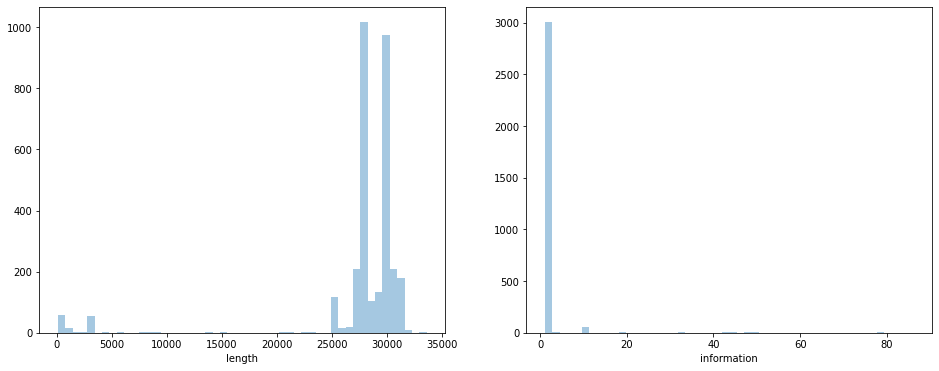

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_orig["length"], kde=False, ax=axs[0]);
sns.distplot(corona_orig["information"], kde=False, ax=axs[1]);

There are a few outliers in the dataset, some genomes are less than ~25k base pairs and some higher than ~32k which is known to be the size range of coronaviruses genomes; most likely some are incomplete sequences or mRNA sequences. Let's take a closer look to this outliers and plot the genome size distribution.

In [5]:
mean = corona_orig["length"].mean()
std = corona_orig["length"].std()

md("$\overline{x} = %.2f$ *bps*"%mean)

$\overline{x} = 27641.33$ *bps*

In [6]:
md("${s} = %.2f$ *bps*"%std)

${s} = 5781.19$ *bps*

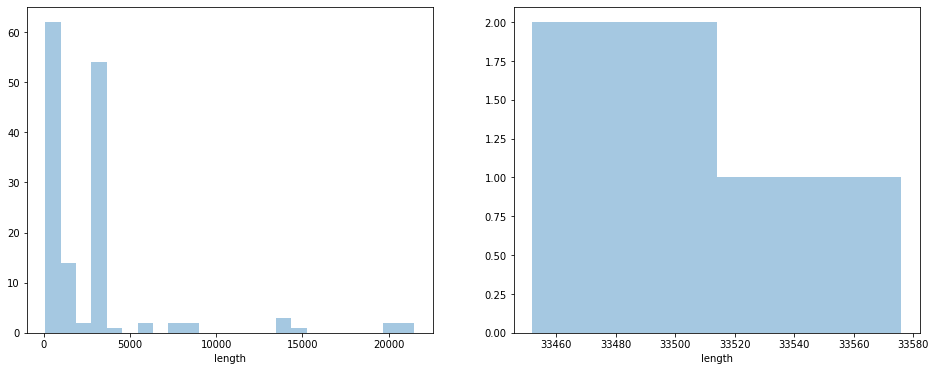

In [7]:
# let's use 1 std to detect outliers
cutoff_left = mean - std
cutoff_right = mean + std

outliers_low = corona_orig[corona_orig["length"] < cutoff_left]
outliers_high = corona_orig[corona_orig["length"] > cutoff_right]
    
if(len(outliers_high) > 0):
    fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
    sns.distplot(outliers_high["length"], kde=False, ax=axs[1]);
    sns.distplot(outliers_low["length"], kde=False, ax=axs[0]);
else:
    plt.figure(figsize=(16, 6))
    sns.distplot(outliers_low["length"], kde=False);

There seems to be some anomalies for cases with a genome below ~16k. Let's look at this cases more closely.

In [8]:
bps_low_limit = 16000
outliers_low_values = outliers_low[outliers_low["length"] < bps_low_limit]
display(HTML(outliers_low_values.drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
5,MT186680.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/257182/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",iran,homo sapiens,unknown,17-Feb-2020
22,MT081068.1,1260,2020-02-20,18.796992,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/HS_194/human/2020/CHN nucleocapsid phosphoprotein (N) gene, complete cds",china,homo sapiens,unknown,06-Feb-2020
26,KF294433.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-127 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus sinicus,unknown,2012
41,KF294439.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-29 RNA-dependent RNA polymerase gene, partial cds",china,miniopterus schreibersii,unknown,2012
95,KF294440.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-97 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus sinicus,unknown,2012
112,KF294382.1,13631,2020-03-16,2.512563,"Anlong Ms bat coronavirus isolate Neixiang-32 orf1ab polyprotein gene, partial cds",china,myotis davidii,unknown,2012
116,KF294427.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-106 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus monoceros,unknown,2012
136,KF294436.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-132 RNA-dependent RNA polymerase gene, partial cds",china,rhinolophus monoceros,unknown,2012
141,KF294376.1,2780,2020-03-16,10.040161,"Lushi Ml bat coronavirus isolate Neixiang-27 RNA-dependent RNA polymerase gene, partial cds",china,murina leucogaster,unknown,2012
156,MT186676.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/1337/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",iran,homo sapiens,unknown,03-Mar-2020


We can grab the top keywrods used in the description of this submissions.

In [9]:
def top_keywords(df):
    descrps = []
    for descrp in df["description"]:
        descrps.append(descrp)
    
    stopwords = ['the','about','an','and','are','at','be','can','for','from','if','in','is','it','of','on','or','that','this','to','you','your','with',]
    tfidf = TfidfVectorizer(max_features=10, stop_words=stopwords)
    tfidf.fit_transform(descrps)
    response = tfidf.transform(descrps)

    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

    top_keyworkds = feature_array[tfidf_sorting][:5]

    display(HTML(pd.DataFrame(top_keyworkds, columns=["keywords"]).to_html()))

top_keywords(outliers_low_values)

,keywords
0,rna
1,partial
2,gene
3,isolate
4,coronavirus


These sequences are partial genomes or isolated genes, we can safely ignore this by setting a genome size cutoff at 16k. 

In [10]:
corona = corona_orig[corona_orig["length"] > bps_low_limit]

Additionally, let's explore the keywords in the description of the remaining submissions.

In [11]:
top_keywords(corona)

,keywords
0,isolate
1,genome
2,complete
3,virus
4,syndrome


Finally let's plot the genome size and information distribution among the remaining samples.

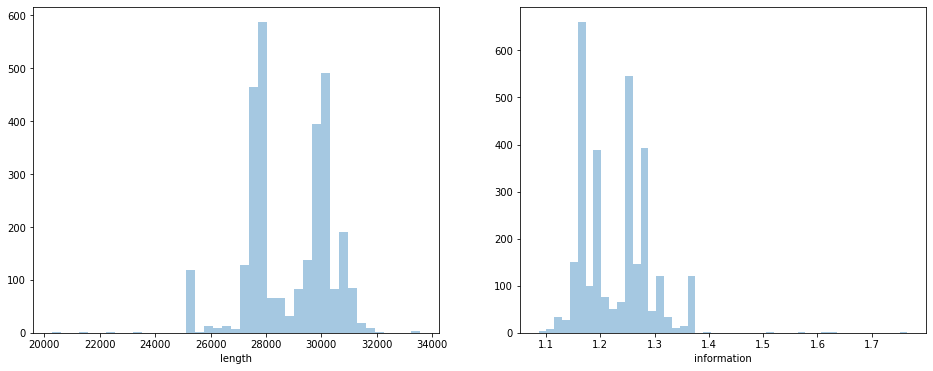

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona["length"], kde=False, ax=axs[0]);
sns.distplot(corona["information"], kde=False, ax=axs[1]);

By looking at the graphs, it seems that both the genome size and information have pretty much the same distribution. We should study the correlation between this two parameters and look for samples outside the general trend. Given the nature of viruses, one would expect that over time the amount of information is preserved regardless of the genome size. This might not be an accurate measure of that behavior, but it's useful to spot anomalies in the data.

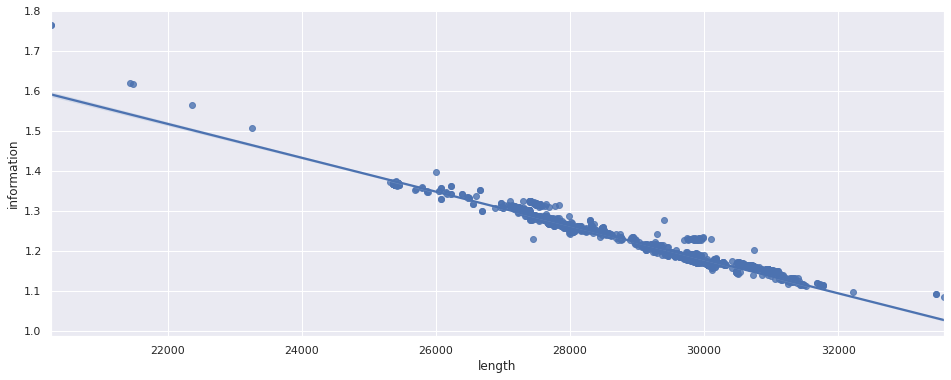

In [13]:
plt.figure(figsize=(16, 6))
sns.set(color_codes=True)
sns.regplot(x="length", y="information", data=corona[["length", "information"]]);

In [14]:
x = corona["length"].values.reshape(-1, 1)
y = corona["information"].values.reshape(-1, 1)
reg = LinearRegression().fit(x, y) 
information_outliers = (100 * (y - reg.predict(x)) / reg.predict(x)) > 5
display(HTML(corona[information_outliers].drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
114,KJ541759.1,33452,2014-08-20,1.093135,"Ball python nidovirus strain 07-53, complete genome",usa,python regius,07-53,01-Jun-2007
614,KF294456.1,21444,2020-03-16,1.621271,"SARS-related bat coronavirus isolate Jiyuan-331 orf1ab polyprotein gene, complete cds",china,rhinolophus ferrumequinum,unknown,2012
757,NC_024709.1,33452,2018-08-13,1.093135,"Ball python nidovirus strain 07-53, complete genome",usa,python regius,07-53,01-Jun-2007
1023,KM589359.1,20261,2015-04-29,1.765537,"Bovine nidovirus TCH5, complete genome",usa,bos taurus,unknown,2013
1910,NC_027199.1,20261,2018-08-13,1.765537,"Bovine nidovirus TCH5, complete genome",usa,bos taurus,unknown,2013
2226,MG600028.1,29409,2018-11-08,1.276813,"Hainan hebius popei torovirus strain LPSC33749 1ab protein, spike protein, and hypothetical protein genes, complete cds",china,hebius popei,LPSC33749,unknown
3041,MG752895.1,33576,2018-01-27,1.086484,"Ball python nidovirus 1 isolate 148, complete genome",usa,python regius,unknown,30-Nov-2016


There are a few anomalies that have information values above (5%) the fitted line, but the more interesting ones are SARS-related KF294456.1 and KF294456.1, with a (pressumably) genome size ~21k and a high amount of information. By looking at the description these are actually complete CDS and not complete genomes. The increase of information could be explained by the removal of the non coding region of the genome. In any case, we'll have to take into account when comparing genomes that some samples might have the non-coding region removed.

In [15]:
md("In total we collected $n = %i$ samples "%(len(corona)))

In total we collected $n = 3000$ samples 

## 1.2. Coronavirus genome time analysis

Another interesting thing to do, it's to analyze how the genome size changed over time, specially on the samples submitted the past month.


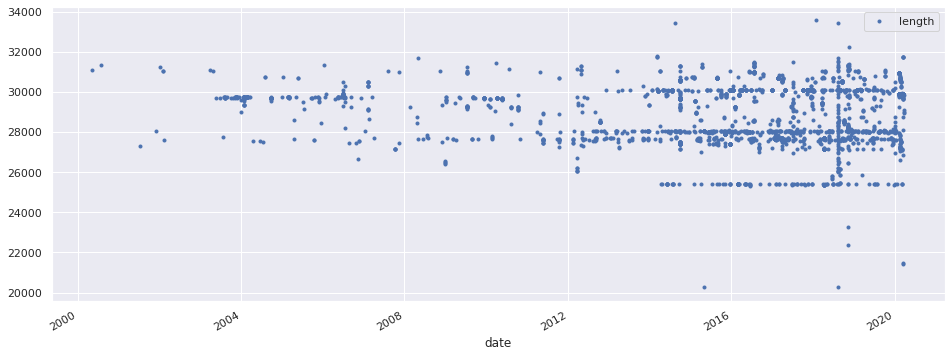

In [16]:
corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

It is clear that there is a diversity on the genome size of the submissions, which might be related that some sequences only represent coding regions and that we are dealing with various species that should be clustered for a deeper analysis per strain. A protein level analysis of the samples will be better to reveal similarities among all the genomes in the dataset. 

What about the samples submitted since december 2019?

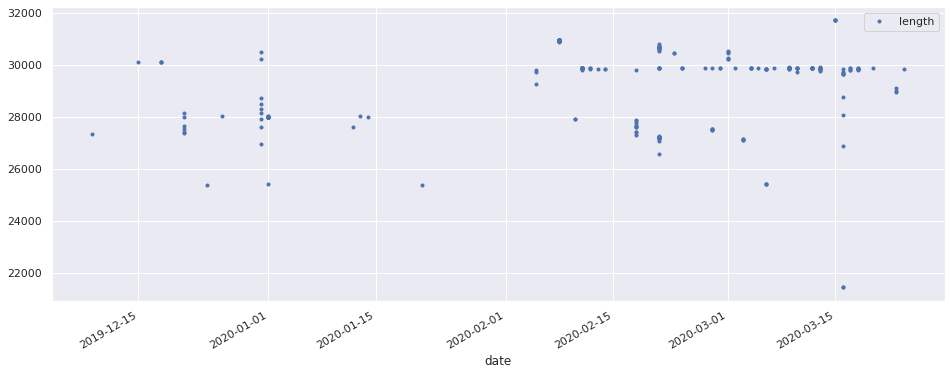

In [17]:
novel_corona = corona[corona["date"] > pd.to_datetime("2019-12-01")]
novel_corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

We know the genome size of the Wuhan virus has a size of 29903 bps. How many samples with that genome size do we have?

In [18]:
ncov = corona[corona["length"] == 29903]
display(HTML(ncov.drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
226,MT163718.1,29903,2020-03-10,1.190476,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA6-UW3/human/2020/USA, complete genome",usa,homo sapiens,unknown,29-Feb-2020
228,MT163719.1,29903,2020-03-10,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA7-UW4/human/2020/USA, complete genome",usa,homo sapiens,unknown,01-Mar-2020
499,MT135043.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/233/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020
630,MT135044.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/235/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020
954,MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
955,MT135041.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/105/human/2020/CHN, complete genome",china,homo sapiens,unknown,26-Jan-2020
1808,MT049951.1,29903,2020-02-12,1.189910,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/Yunnan-01/human/2020/CHN, complete genome",china,homo sapiens,unknown,17-Jan-2020
1864,MT039890.1,29903,2020-02-11,1.191611,"Severe acute respiratory syndrome coronavirus 2 isolate SNU01, complete genome",south korea,homo sapiens,unknown,Jan-2020
1878,NC_045512.2,29903,2020-03-13,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
2004,MT135042.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/231/human/2020/CHN, complete genome",china,homo sapiens,unknown,28-Jan-2020


All of them were reported this year, consistently with what we know.

In [19]:
md("Total ncov samples $n = %i$ samples "%(len(ncov)))

Total ncov samples $n = 12$ samples 

From all these SARS-CoV-2 samples, which one we should use as a reference for a genome variation analysis? We should look at the collection date (which is different from the date in the genbank annotations) and use the ones collected in december 2019.

In [20]:
reference_corona = corona[corona["collection_date"] == "Dec-2019"]
display(HTML(reference_corona.drop(hidden_columns, axis=1).to_html()))

,id,length,date,information,description,country,host,strain,collection_date
954,MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019
1878,NC_045512.2,29903,2020-03-13,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",china,homo sapiens,unknown,Dec-2019


## 1.2. Host and country distribution

Let's analyze the host and conuntry distribution for all time samples and novel samples (submissions after december 2019)

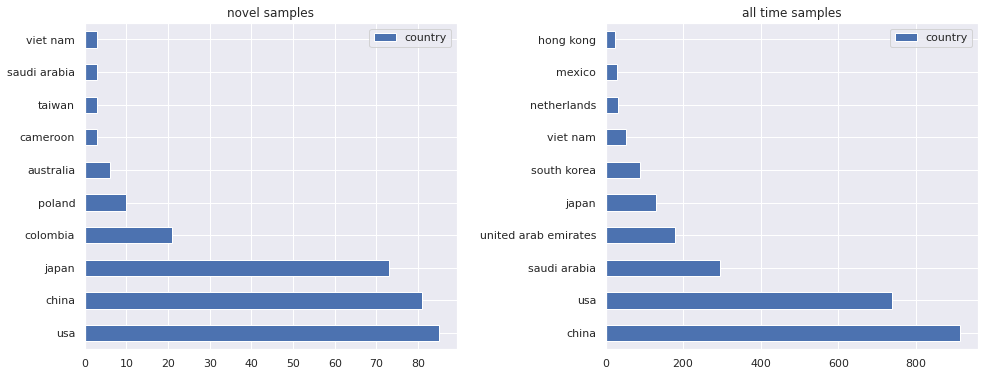

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

countries = pd.DataFrame(novel_corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

countries = pd.DataFrame(corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

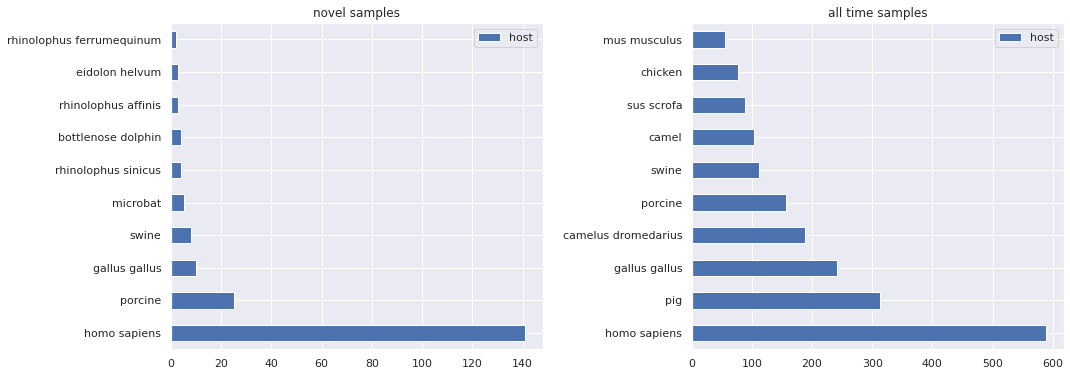

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

hosts = pd.DataFrame(novel_corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

hosts = pd.DataFrame(corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

# 3. Genome sequence analysis <a id="section3"></a>

Now we have a pretty good picture of the data available. But what does this virus actually do? What does it look like? In order to have a better understanding we should analyze the coding sequences on the genome, which determines the sequence of amino acids in the protein that the virus needs to replicate.